In [ ]:
# 🚀 Ortal's Final Multi-HuggingFace Dataset EDA Notebook (Cleaned with Verified Datasets)

# Step 1: Install dependencies
!pip install duckdb datasets pandas matplotlib wordcloud seaborn nltk

# Step 2: Import libraries
import duckdb
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
from collections import Counter
import os
import math

# Step 3: Download NLTK tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

# Step 4: Define mental health dataset list
datasets_list = [
    "Peraboom/ADHD_Related_Concerns",
    "thePixel42/depression-detection",
    "joangaes/depression",
    "solomonk/reddit_mental_health_posts"
]

# Step 5: Manual column mapping for tricky datasets
custom_column_map = {
    "Peraboom/ADHD_Related_Concerns": {"text": "body", "label": "score_binary"},
    "solomonk/reddit_mental_health_posts": {"text": "body", "label": "score_binary"},
    "thePixel42/depression-detection": {"text": "text", "label": "label"},
    "joangaes/depression": {"text": "text", "label": "label"}
}

# Step 6: Create results folder
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
failed_datasets_path = os.path.join(results_dir, "failed_datasets.txt")

# Step 7: Helper functions

def calculate_entropy(counts):
    total = sum(counts)
    return -sum((count/total) * math.log2(count/total) for count in counts if count > 0)

def detect_columns(df, dataset_name):
    if dataset_name in custom_column_map:
        return custom_column_map[dataset_name]["text"], custom_column_map[dataset_name]["label"]
    text_column = next((col for col in df.columns if any(key in col.lower() for key in ['text', 'post', 'content', 'message', 'comment', 'body', 'sentence'])), None)
    label_column = next((col for col in df.columns if any(key in col.lower() for key in ['label', 'target', 'category', 'concern', 'therapy', 'condition', 'score_binary'])), None)
    return text_column, label_column

def explore_dataset(df, dataset_name, dataset_dir):
    print(f"\n🚀 Analyzing: {dataset_name}")

    if dataset_name in ["Peraboom/ADHD_Related_Concerns", "solomonk/reddit_mental_health_posts"]:
        score_col = "score" if "score" in df.columns else "upvote_ratio"
        median_score = df[score_col].median()
        df["score_binary"] = df[score_col].apply(lambda x: 1 if x >= median_score else 0)

    text_col, label_col = detect_columns(df, dataset_name)
    if text_col is None or label_col is None:
        print(f"⚠️ Skipped {dataset_name}: No proper text/label columns found.")
        return

    con = duckdb.connect()
    con.register('dataset', df)
    os.makedirs(dataset_dir, exist_ok=True)

    class_balance = con.execute(f"SELECT {label_col} AS label, COUNT(*) AS count FROM dataset GROUP BY {label_col}").fetchdf()
    class_balance.to_csv(os.path.join(dataset_dir, "class_balance.csv"), index=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='count', data=class_balance, palette='viridis')
    plt.title(f'Class Balance: {dataset_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(dataset_dir, "class_balance_plot.png"))
    plt.close()

    avg_length = con.execute(f"SELECT AVG(LENGTH({text_col})) AS avg_text_length FROM dataset").fetchdf()
    avg_length.to_csv(os.path.join(dataset_dir, "avg_text_length.csv"), index=False)

    avg_length_by_label = con.execute(f"SELECT {label_col} AS label, AVG(LENGTH({text_col})) AS avg_text_length FROM dataset GROUP BY {label_col}").fetchdf()
    avg_length_by_label.to_csv(os.path.join(dataset_dir, "avg_length_by_label.csv"), index=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='label', y='avg_text_length', data=avg_length_by_label, palette='coolwarm')
    plt.title(f'Avg Text Length by Label: {dataset_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(dataset_dir, "avg_text_length_plot.png"))
    plt.close()

    entropy = calculate_entropy(class_balance['count'].tolist())
    pd.DataFrame({'entropy': [entropy]}).to_csv(os.path.join(dataset_dir, "entropy.csv"), index=False)

    all_text = ' '.join(df[text_col].astype(str))
    tokens = nltk.word_tokenize(all_text.lower())
    filtered_tokens = [word for word in tokens if len(word) > 3 and word.isalpha()]
    word_counts = Counter(filtered_tokens)
    most_common_words = word_counts.most_common(50)
    pd.DataFrame(most_common_words, columns=['word', 'count']).to_csv(os.path.join(dataset_dir, "word_counts.csv"), index=False)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(dataset_dir, "wordcloud.png"))
    plt.close()

    print(f"✅ Completed: {dataset_name}. Results in: {dataset_dir}")

# Step 8: Run analysis for each dataset
failed_datasets = []

for dataset_name in datasets_list:
    safe_name = dataset_name.replace('/', '_').replace('-', '_')
    dataset_dir = os.path.join(results_dir, safe_name)
    try:
        df = load_dataset(dataset_name, split='train').to_pandas()
        explore_dataset(df, dataset_name, dataset_dir)
    except Exception as e:
        print(f"⚠️ Failed {dataset_name}: {e}")
        failed_datasets.append(dataset_name)

if failed_datasets:
    with open(failed_datasets_path, 'w') as f:
        for name in failed_datasets:
            f.write(name + '\n')
    print(f"\n⚠️ Some datasets failed to load. See: {failed_datasets_path}")

print("\n🎉 All datasets processed successfully (with skips if needed). Check the 'results' folder.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

adhd.csv:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37109 [00:00<?, ? examples/s]


🚀 Analyzing: Peraboom/ADHD_Related_Concerns


<ipython-input-1-f212ffb6d432>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_balance, palette='viridis')
<ipython-input-1-f212ffb6d432>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='avg_text_length', data=avg_length_by_label, palette='coolwarm')


✅ Completed: Peraboom/ADHD_Related_Concerns. Results in: results/Peraboom_ADHD_Related_Concerns


README.md:   0%|          | 0.00/536 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/107M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/140000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]


🚀 Analyzing: thePixel42/depression-detection


<ipython-input-1-f212ffb6d432>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_balance, palette='viridis')
<ipython-input-1-f212ffb6d432>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='avg_text_length', data=avg_length_by_label, palette='coolwarm')


✅ Completed: thePixel42/depression-detection. Results in: results/thePixel42_depression_detection


clean_encoded_df.csv:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27977 [00:00<?, ? examples/s]


🚀 Analyzing: joangaes/depression


<ipython-input-1-f212ffb6d432>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_balance, palette='viridis')
<ipython-input-1-f212ffb6d432>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='avg_text_length', data=avg_length_by_label, palette='coolwarm')


✅ Completed: joangaes/depression. Results in: results/joangaes_depression


README.md:   0%|          | 0.00/425 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


adhd.csv:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

aspergers.csv:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

depression.csv:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

ocd.csv:   0%|          | 0.00/29.8M [00:00<?, ?B/s]

ptsd.csv:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/151288 [00:00<?, ? examples/s]


🚀 Analyzing: solomonk/reddit_mental_health_posts


<ipython-input-1-f212ffb6d432>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=class_balance, palette='viridis')
<ipython-input-1-f212ffb6d432>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='avg_text_length', data=avg_length_by_label, palette='coolwarm')


✅ Completed: solomonk/reddit_mental_health_posts. Results in: results/solomonk_reddit_mental_health_posts

🎉 All datasets processed successfully (with skips if needed). Check the 'results' folder.


In [ ]:
# ========================
# ⬇️ Code Block to Zip and Download All Results
# ========================


import shutil
from IPython.display import FileLink

# Zip the entire results folder
shutil.make_archive("results_zip", 'zip', "results")

# Provide a download link
FileLink("results_zip.zip")

/content/results_zip.zip

For streamlit dashboard for extra comparison and analysis:

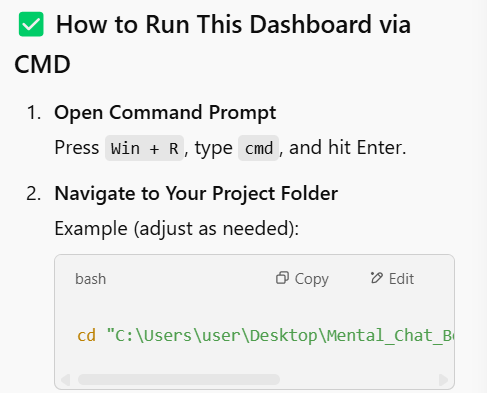

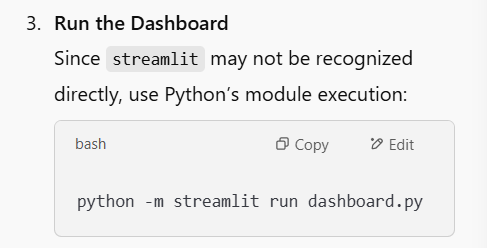

sometimes it has issues so we need to do this:

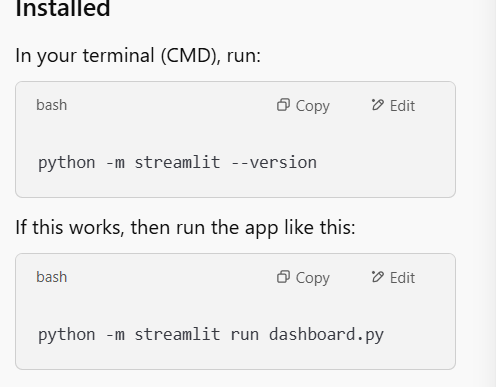

also this is the dashboard.py code block which you need to save to a different jupiter notebook in the same folder as the EDA_results, and only then do what is written above.

In [ ]:
# 📊 Streamlit Dashboard Code (Save as `dashboard.py`)
"""
import streamlit as st
import pandas as pd
import os

st.title("📊 Mental Health Datasets Comparison Dashboard")

# Use absolute path if needed, fallback to local folder
results_dir = os.path.abspath("EDA_results")
dataset_dirs = [f for f in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, f))]

for ds in dataset_dirs:
    st.subheader(f"📁 Dataset: {ds}")
    ds_path = os.path.join(results_dir, ds)

    col1, col2 = st.columns(2)

    with col1:
        plot1 = os.path.join(ds_path, "class_balance_plot.png")
        plot2 = os.path.join(ds_path, "avg_text_length_plot.png")
        if os.path.exists(plot1):
            st.image(plot1, caption="Class Balance")
        if os.path.exists(plot2):
            st.image(plot2, caption="Avg Text Length by Label")

    with col2:
        wc = os.path.join(ds_path, "wordcloud.png")
        if os.path.exists(wc):
            st.image(wc, caption="Word Cloud")

    entropy_path = os.path.join(ds_path, "entropy.csv")
    if os.path.exists(entropy_path):
        entropy = pd.read_csv(entropy_path)
        if 'entropy' in entropy.columns:
            st.metric(label="🔀 Entropy (Label Diversity)", value=round(entropy['entropy'][0], 3))
    """

SyntaxError: incomplete input (<ipython-input-8-98cb95b4449d>, line 2)